#### Plotting example notebook for general properties from LoSSETT output - example using DYAMOND Summer 40-day time mean CTC N2560 RAL3.2

In [6]:
import os
import sys
from pathlib import Path
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import cartopy as cpy
import datetime as dt
import cartopy.crs as ccrs
import matplotlib.ticker as ticker

In [7]:
DATA_DIR = "/work/scratch-pw2/dship/LoSSETT/output/kscale/DYAMOND_SUMMER_0p5deg/"
simid = 'CTC5RAL'
n_scales = 32
fpath_mean = os.path.join(
        DATA_DIR,
        f"DR_test_{simid}_Nl_{n_scales}_DyS_time-mean.nc"
    )

if not os.path.exists(fpath_mean):
    print('mean file doesnt exist - compute')

In [8]:
ds_DR_mean = xr.open_dataset(fpath_mean)
ds_DR_mean

<xarray.Dataset> Size: 294MB
Dimensions:                  (length_scale: 32, latitude: 133, longitude: 720,
                              pressure: 12)
Coordinates:
  * length_scale             (length_scale) float64 256B 5.5e+04 ... 1.76e+06
    forecast_reference_time  datetime64[ns] 8B ...
  * latitude                 (latitude) float64 1kB -40.0 -39.5 ... 25.5 26.0
  * longitude                (longitude) float64 6kB -180.0 -179.5 ... 179.5
  * pressure                 (pressure) float32 48B 100.0 150.0 ... 925.0 1e+03
Data variables:
    DR_indicator             (length_scale, latitude, pressure, longitude) float64 294MB ...

In [9]:
DR_mean = ds_DR_mean['DR_indicator']
DR_mean

<xarray.DataArray 'DR_indicator' (length_scale: 32, latitude: 133,
                                  pressure: 12, longitude: 720)> Size: 294MB
[36771840 values with dtype=float64]
Coordinates:
  * length_scale             (length_scale) float64 256B 5.5e+04 ... 1.76e+06
    forecast_reference_time  datetime64[ns] 8B ...
  * latitude                 (latitude) float64 1kB -40.0 -39.5 ... 25.5 26.0
  * longitude                (longitude) float64 6kB -180.0 -179.5 ... 179.5
  * pressure                 (pressure) float32 48B 100.0 150.0 ... 925.0 1e+03

##### Quick map plot for chosen length scale

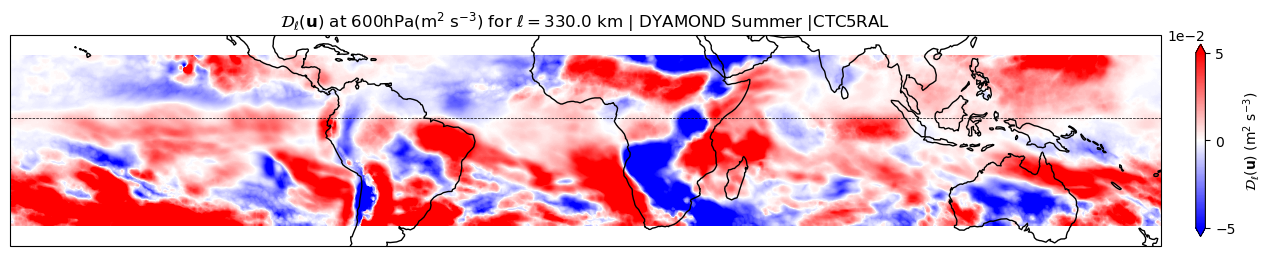

In [14]:
ell = 330000
lvl=600
DR_map = DR_mean.sel(pressure=lvl,length_scale=ell,method='nearest')
# DR_map
plt.figure(figsize=(18,10))
ax = plt.axes(projection=ccrs.PlateCarree())
lon = DR_mean['longitude']
lat = DR_mean['latitude']
# ax.set_extent([180,-180,-85,85],crs=ccrs.PlateCarree())
plt.contourf(lon,lat,DR_map,cmap='bwr',levels=np.arange(-0.00005,0.00005,5e-7),extend='both')
ax.coastlines()
plt.title(r'$\mathcal{D}_\ell(\mathbf{u})$ at'+f' {lvl}hPa'+r'(m$^2$ s$^{-3}$) for $\ell = '+f'{ell/1000}$ km | DYAMOND Summer |'+f'{simid}')
cbar=plt.colorbar(orientation='vertical', shrink=0.25, pad=0.025)
cbar.set_label(r'$\mathcal{D}_\ell(\mathbf{u})$ (m$^2$ s$^{-3}$)')
ax.axhline(y=0,color='k',linewidth=0.5,linestyle='--')
cbar.formatter = ticker.ScalarFormatter()
cbar.formatter.set_scientific(True)
cbar.formatter.set_powerlimits((-2, 3))
cbar.update_ticks() 
cbar.set_ticks([-0.05,0,0.05])

##### Longitudinally averaged vertical slice (as seen on the flyer)

In [12]:
DR_vertslice_2D_lat = DR_mean.sel(length_scale=ell,method='nearest').mean(dim='longitude')
DR_vertslice_2D_lat

<xarray.DataArray 'DR_indicator' (latitude: 133, pressure: 12)> Size: 13kB
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
    length_scale             float64 8B 9.9e+05
    forecast_reference_time  datetime64[ns] 8B ...
  * latitude                 (latitude) float64 1kB -40.0 -39.5 ... 25.5 26.0
  * pressure                 (pressure) float32 48B 100.0 150.0 ... 925.0 1e+03

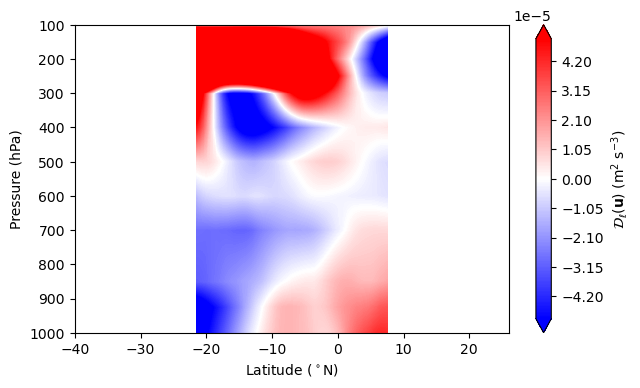

In [14]:
fig,ax = plt.subplots(figsize=(7,4))
CS = ax.contourf(DR_vertslice_2D_lat['latitude'],
             DR_vertslice_2D_lat['pressure'],
             DR_vertslice_2D_lat.T,
             cmap='bwr',
             levels=np.arange(-0.00005,0.00005,5e-7),extend='both')
ax.invert_yaxis()
# ax.set_yscale('log')
ax.set_ylabel('Pressure (hPa)')
ax.set_xlabel(r'Latitude ($^\circ$N)')
# ax.set_xlim([-20,20])
fig.colorbar(CS, ax=ax, orientation='vertical', label=r'$\mathcal{D}_\ell(\mathbf{u})$ (m$^2$ s$^{-3}$)')

##### Banding of $\mathcal{D}_\ell$ to quantify energy *into* a band of scales. Logic is:

$\Delta\mathcal{D}_{\ell}(\ell_1,\ell_2) = \mathcal{D}_{\ell_1} - \mathcal{D}_{\ell_2}$ for $\ell_1 > \ell_2$

At the upper and lower bounds of $\ell$:

$\Delta\mathcal{D}_\ell(\ell_{min},0) = \mathcal{D}_{\ell_{min}} \ ;$

$\Delta\mathcal{D}_\ell(\infty,\ell_{max}) = -\mathcal{D}_{\ell_{max}}.$

In [5]:
ell_band_S = [110000]
ell_band_M = [110000, 440000]
ell_band_L = [440000, 1100000]
ell_band_XL = [1100000]

In [6]:
delta_DR_S = DR_mean.sel(length_scale=ell_band_S[0])
delta_DR_M = DR_mean.sel(length_scale=ell_band_M[-1]) - DR_mean.sel(length_scale=ell_band_M[0])
delta_DR_L = DR_mean.sel(length_scale=ell_band_L[-1]) - DR_mean.sel(length_scale=ell_band_L[0])
delta_DR_XL = -DR_mean.sel(length_scale=ell_band_XL[0])

##### Plotting: Banded $\mathcal{D}_\ell$ vs. $\ell$

Text(0.5, 0, 'Scale range (km)')

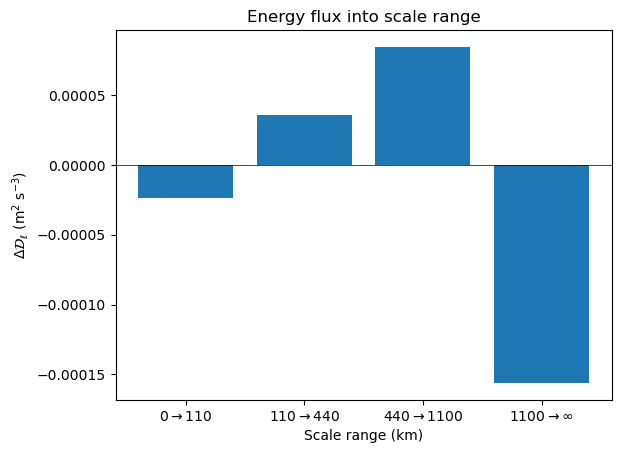

In [7]:
fig,ax = plt.subplots(1,1)
lvl = 200
vals = [delta_DR_S.sel(pressure=lvl,latitude=slice(-15,15)).mean(dim=['latitude','longitude']),\
        delta_DR_M.sel(pressure=lvl,latitude=slice(-15,15)).mean(dim=['latitude','longitude']),\
        delta_DR_L.sel(pressure=lvl,latitude=slice(-15,15)).mean(dim=['latitude','longitude']),\
        delta_DR_XL.sel(pressure=lvl,latitude=slice(-15,15)).mean(dim=['latitude','longitude'])]
sizes = [r'0$\to$110',r'110$\to$440',r'440$\to$1100',r'1100$\to\infty$']
# colors = ['','','','']
ax.bar(sizes,vals)
ax.axhline(0,linewidth=0.5,color='k')
ax.set_title('Energy flux into scale range')
ax.set_ylabel(r'm$^2$ s$^{-3}$')
ax.set_xlabel('Scale range (km)')